# Plot polygons over SKR Flux
This notebook demonstrates how to plot polygons on top of an SKR spectrogram for a specific time frame.

In [2]:
from datetime import datetime
import numpy as np

from scipy.io import readsav

import matplotlib.pyplot as plt
import matplotlib.colors as mp_colors
import matplotlib.dates as mdates
from matplotlib.patches import Polygon

from tfcat import TFCat

In [3]:
def get_sav_data(year):
    """Select sav data for a chosen year.
    
    Parses through an SKR year file to obtain the time, frequency and flux data.
    
    Parameters
    ----------
    year: int or str
        Year of the file wanted.
    
    Returns
    -------
    time: numpy.array
        Time series in 3 minute step.

    freq: numpy.array
        Midpoint values of Cassini frequency bins.

    flux: numpy.array (freq.shape, time.shape)
        Magnetic flux values for the chosen year.
    """

    skr_raw_fp = '../data/raw/SKR_raw'

    file_skr = skr_raw_fp + f'/SKR_{year}_CJ.sav'
    raw_skr = readsav(file_skr)
    flux, time_doy, freq = raw_skr['s'].copy(), raw_skr['t'], raw_skr['f']
    flux[flux == 0] = np.nan  # replace 0 with nans

    time = (time_doy * 24 * 3600).astype('timedelta64[s]') + np.datetime64('1997') - np.timedelta64(1, 'D') + np.timedelta64(1, 's') # SAV time correction
    time = time.astype('datetime64[m]')
    time = time.astype('datetime64[s]')

    return time, freq, flux

Define file paths

In [4]:
file_catalogue = '../data/calculated/2004001_2017258_joint_catalogue.json'
#file_catalogue = '../data/raw/2004001_2017258_catalogue.json'

Choose limits of time window

In [5]:
start, stop = '2015-10-11', '2015-10-13' # Change limits here

start_date = datetime.strptime(start, '%Y-%m-%d') # Only used for title formatting
stop_date = datetime.strptime(stop, '%Y-%m-%d') # Only uesd for title formatting

time_low, time_high = mdates.date2num(np.datetime64(start)), mdates.date2num(np.datetime64(stop)) # Used in Calculations

Read Sav file

In [6]:
year = start[:4]
time, frequency, flux = get_sav_data(year)

Import Polygon coordinates

In [7]:
catalogue = TFCat.from_file(file_catalogue)

poly_coordinates = []
for i in range(len(catalogue._data['features'])):
    poly_time, poly_freq = np.array(catalogue._data['features'][i]['geometry']['coordinates'][0]).T

    poly_time = poly_time.astype('datetime64[s]')

    poly_coords = np.array([mdates.date2num(poly_time), poly_freq]).T

    poly_coordinates.append(poly_coords)

Draw the Figure

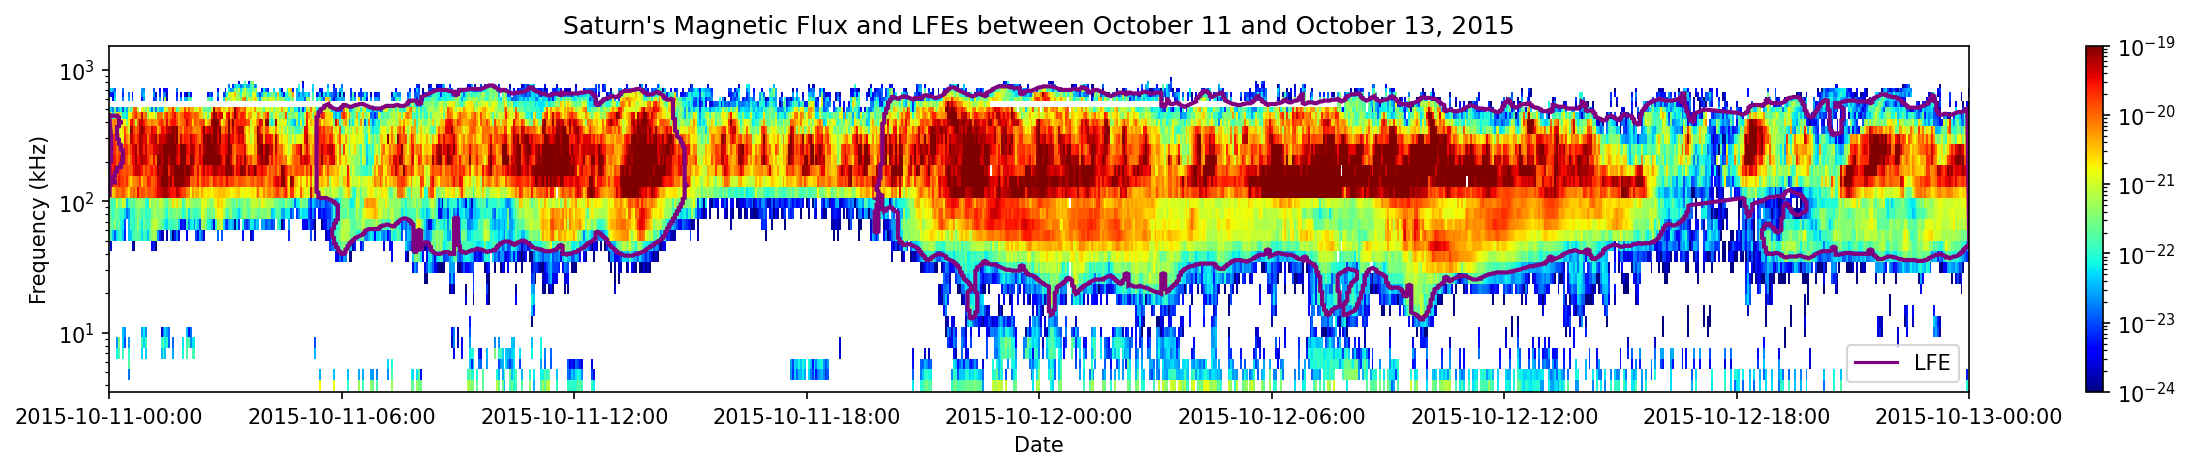

In [8]:
fig = plt.figure(figsize=(20,3), dpi=150)

ax = fig.add_subplot()

norm = mp_colors.LogNorm(vmin=1e-24, vmax=1e-19)

cbar = ax.pcolormesh(time, frequency, flux, norm=norm, cmap='jet')

for poly_coords in poly_coordinates:
    
    poly_time = poly_coords[:,0]
    time_mask = (poly_time >= time_low) & (poly_time <= time_high)

    ax.add_patch(Polygon(poly_coords[time_mask], fill=False, lw=2, color='purple'))

ax.plot([], [], color='purple', label='LFE')

fig.colorbar(cbar)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d-%H:%M'))
ax.set_xlim(time_low, time_high)
#ax.set_ylim(50, 500)
ax.set_yscale('log')

ax.set_title(f"Saturn's Magnetic Flux and LFEs between {start_date.strftime('%B %d')} and {stop_date.strftime('%B %d')}, {year}")
ax.set_xlabel('Date')
ax.set_ylabel('Frequency (kHz)')
ax.legend(loc='lower right');